In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr as R
import sklearn.metrics as mets
import timeit
from toolz import pipe as p

import utils

In [2]:
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\jod204\\projects\\mesh-project\\utils.py'>

In [9]:
cr_data = R.read_r('pubmed_cr_abstracts.RDS')[None]

cr_data = cr_data.fillna('na')
cr_data['txt'] = cr_data.title + ' . ' + cr_data.abstract

In [10]:
cr_data.shape

(1293, 6)

In [11]:
sum(cr_data.label)

598.0

In [12]:
sum(1-cr_data.label)

695.0

In [13]:
cr_data.columns

Index(['pmid', 'yr', 'title', 'abstract', 'label', 'txt'], dtype='object')

Merge title and abstract

In [14]:
type(cr_data.pmid[0])

str

In [17]:
project_data = cr_data[['pmid', 'txt', 'label']]
project_data['label'] = project_data['label'] == 1.0
project_data.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pmid,txt,label
0,21218043,Acute liver failure associated with occupation...,True
1,26000001,A successful pregnancy during the treatment of...,False
2,23792523,"AST 17600 U/l after liver transplantation, wha...",True
3,25034585,[Pulmonary benign metastasizing leiomyoma: a c...,False
4,25026126,Two novel mutations in acid α-glucosidase gene...,False


In [18]:
len(project_data.loc[0, 'txt'])

1076

In [19]:
len(project_data.txt[0])

1076

## Clean Data

In [20]:
clean_data = project_data
clean_data.txt = [utils.cleanTxt(txt) for txt in clean_data.txt]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
clean_data.shape

(1293, 3)

Traditional machine learning without </s\>

In [22]:
clean_data_tr = clean_data.copy()
clean_data_tr.txt = [txt.replace('</s>', '') for txt in clean_data_tr.txt]

In [23]:
clean_data_tr.groupby('label').count()

,pmid,txt
label,,
False,695,695
True,598,598


## Tokenize Text

In [24]:
import keras

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

__Check using GPU__

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11163671754494459582
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9119690261
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15318643949139165673
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9118843535
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9977492471505416626
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


GPU shown

In [26]:
max_vocab = 20000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = max_vocab, filters = "")

In [27]:
tokenizer.fit_on_texts(clean_data.txt)

In [28]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [29]:
vocab_size

13767

Get document word counts

In [30]:
data_explore = clean_data_tr.copy()

# let's convert the sentences to sequences using the tokenizer
data_seq = tokenizer.texts_to_sequences(clean_data.txt)
word_counts = [len(sq) for sq in data_seq]

# add field to data frame:
data_explore['WordCnt'] = word_counts

# use user friendly labels for plotting
#levels(data_explore$label) <- c("CTL", "CIR")

# what's our word count range and median?
minmax = lambda arr: (np.min(arr), np.max(arr))

print(minmax(word_counts))
print(np.median(word_counts))

(32, 571)
158.0


Same as R output of (32, 157) and 158.

In [31]:
print("total words in corpus: " + str(sum(word_counts)))

total words in corpus: 219718


In [32]:
data_explore.head()

,pmid,txt,label,WordCnt
0,21218043,acute liver failure associated with occupation...,True,161
1,26000001,a successful pregnancy during the treatment of...,False,327
2,23792523,ast _lgnum_ u l after liver transplantation wh...,True,221
3,25034585,pulmonary benign metastasizing leiomyoma a cli...,False,176
4,25026126,two novel mutations in acid - glucosidase gene...,False,118


## Plots

In [33]:
import wordcloud
from wordcloud import WordCloud

In [34]:
word_list_to_string = lambda ws: ' '.join(ws)

words = word_list_to_string(clean_data_tr.txt)

min_word_count = 6
view_word = lambda word: (
    '_' not in word and 
    tokenizer.word_docs[word] > min_word_count - 1 and 
    '-' not in word
    and word not in wordcloud.STOPWORDS
)

filtered_words = word_list_to_string(
    [w for w in words.split(' ') if view_word(w)]
)

In [35]:
len(words)

1381675

In [36]:
words[1:100]

'cute liver failure associated with occupational exposure to tetrachloroethylene   tetrachloroethyle'

In [37]:
len(filtered_words)

843087

In [38]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
wcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = wordcloud.STOPWORDS, 
                min_font_size = 10).generate(filtered_words)  
 

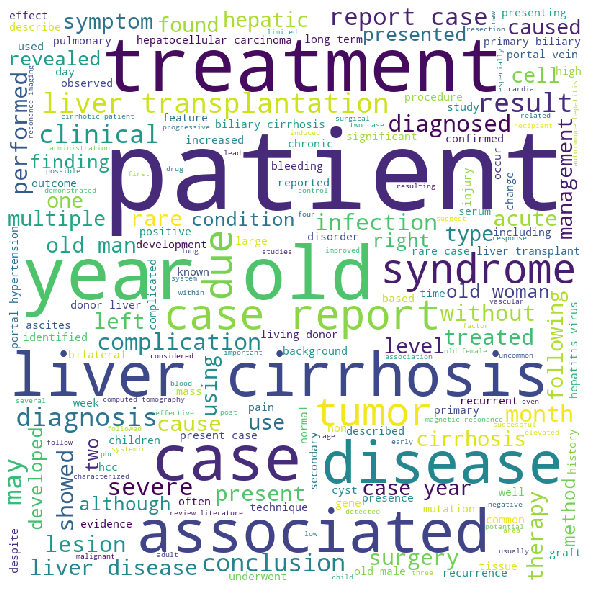

In [39]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [40]:
tokenizer.word_counts['patients']

1049

## Compare Group Frequencies

In [41]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
count_vec = CountVectorizer()
dfm_data = count_vec.fit_transform(clean_data_tr.txt)

dfm = pd.DataFrame(dfm_data.toarray(), columns = count_vec.get_feature_names())

In [43]:
dfm.head()

,08,10,11,12,13,14,15,16,17,18,...,zoonotic,zoster,zosteriform,zr,zsef,zurich,zygoma,zygomatic,zygomycetes,zygomycosis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
tokenizer.word_counts['zoonotic']

1

In [45]:
dfm.shape

(1293, 13712)

In [46]:
from sklearn import feature_selection

In [47]:
(chi_features_stat, chi_features_p) = feature_selection.chi2(dfm_data, clean_data.label)

In [48]:
np.where(dfm.columns == "liver")

(array([7164], dtype=int64),)

In [49]:
chi_features_stat[7452]

13.12230284573106

In [50]:
chi_features_p[7452]

0.0002918011398840433

In [51]:
keyness_df = pd.DataFrame(dfm.columns,
                          columns=['term'])
keyness_df['chi2_stat'] = chi_features_stat
keyness_df['chi2_p'] = chi_features_p

In [52]:
keyness_df.sort_values(by='chi2_stat', ascending=False).head(19)

,term,chi2_stat,chi2_p
7164,liver,1610.206877,0.000000e+00
2102,cirrhosis,1035.307444,3.800423e-227
5582,hepatitis,379.934691,1.285820e-84
12746,transplantation,354.440767,4.572113e-79
9633,portal,331.151203,5.395791e-74
5575,hepatic,309.630391,2.628704e-69
1394,biliary,211.481705,6.525370e-48
3556,donor,181.766707,1.993823e-41
13306,vein,167.155077,3.094255e-38
9169,pbc,151.086957,1.003188e-34


In [53]:

keyness_df[
    [t in ("nerve", "melanoma", "sarcoma") for t in keyness_df.term]].sort_values(by = 'chi2_stat')

,term,chi2_stat,chi2_p
7563,melanoma,24.952518,5.875974e-07
11045,sarcoma,26.673381,2.409177e-07
8261,nerve,72.902752,1.361981e-17


In [54]:
case_rows = [l == 1 for l in clean_data.label]

np.mean(dfm.nerve[case_rows])

0.0016722408026755853

In [55]:
np.mean(dfm.nerve[np.logical_not(case_rows)])

0.12661870503597122

## Deep Learning

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
#cr_train = R.read_r('cr_train.RDS')[None]
#cr_test = R.read_r('cr_test.RDS')[None]

#loadX = lambda df: df['txt'].to_numpy()
#loadY = lambda df: df['label'].to_numpy() == 'YES'

#X_train = loadX(cr_train)
#y_train = loadY(cr_train)

#X_test = loadX(cr_test)
#y_test = loadY(cr_test)

#r_train_ixs = pd.read_csv('r_train_ixs.csv')['Resample1'].to_numpy()

#clean_data['txt'] = clean_data['txt'].astype('str')
#all_ixs = set(clean_data.index)

#train_ixs = set(r_train_ixs).intersection(all_ixs)

#test_ixs = all_ixs - train_ixs

#ordering important
#train_ixs = list(train_ixs)
#test_ixs = list(test_ixs)


#X_train = clean_data['txt'][train_ixs].astype('str')
#X_test = clean_data['txt'][test_ixs].astype('str')

#y_train = clean_data['label'][train_ixs].astype('bool')
#y_test = clean_data['label'][test_ixs].astype('bool')
(X_train, X_test, y_train, y_test) =  train_test_split(
    clean_data.txt, clean_data.label, 
                            test_size = .3, stratify = clean_data.label)

In [58]:
print(X_train.describe())
print('\n')
print(X_test.describe())

count                                                   905
unique                                                  905
top       preservation of facial nerve function repaired...
freq                                                      1
Name: txt, dtype: object


count                                                   388
unique                                                  388
top       unilateral nipple eczema in children report of...
freq                                                      1
Name: txt, dtype: object


In [59]:
print(y_train.describe())
print('\n')
print(y_test.describe())

count       905
unique        2
top       False
freq        486
Name: label, dtype: object


count       388
unique        2
top       False
freq        209
Name: label, dtype: object


In [60]:
max_vocab = 20000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = max_vocab, filters = "")
cr_data = R.read_r('cr_data.RDS')[None]
tokenizer.fit_on_texts(cr_data['txt'])
cr_seq = tokenizer.texts_to_sequences(cr_data['txt'])

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [61]:
print('Vocab Size: ' + str(len(tokenizer.word_index)))

Vocab Size: 14019


In [62]:
maxlen = np.max([len(sent) for sent in cr_seq]) + 1

In [63]:
maxlen

572

In [64]:
X_train_pad = keras.preprocessing.sequence.pad_sequences(
    seq_train, maxlen = maxlen)
X_test_pad = keras.preprocessing.sequence.pad_sequences(
    seq_test, maxlen = maxlen)

#loadRDS = lambda f: R.read_r(f)[None].to_numpy()

#X_train_pad = loadRDS('X_train.RDS')
#X_test_pad = loadRDS('X_test.RDS')
#y_train = loadRDS('y_train.RDS') == 1
#y_test = loadRDS('y_test.RDS') == 1
#X_train_pad = keras.preprocessing.sequence.pad_sequences(
#    seq_train, maxlen=maxlen)
#X_test_pad = keras.preprocessing.sequence.pad_sequences(
#    seq_test, maxlen=maxlen)

Shape of data tensor

In [65]:
maxlen = X_train_pad.shape[1]
X_train_pad.shape

(905, 572)

In [66]:
np.unique(y_train)

array([False,  True])

In [67]:
np.unique(y_test)

array([False,  True])

Comparable proportions

In [68]:
{i:np.sum(y_train == i) for i in (0, 1)}

{0: 486, 1: 419}

In [69]:
{i:np.sum(y_test == i) for i in (0, 1)}

{0: 209, 1: 179}

## No Pre-training

In [70]:
def buildCnn(EMBEDDING_DIM = 50,
                      num_filters = 100,
                      maxlen = 600,
                      vocab_size = 10000,
                      pre_trained = False,
                      embedding_matrix = None,
                      trainable_embed=True):
    
    hidden_dims = 128
    filt_sz = (3, 4, 5)
    
    drop_rate = 0.2

    inputs = keras.layers.Input(shape = [maxlen], name = "input")
    if(not pre_trained):
        embedding_lyr = p(inputs,
                          keras.layers.Embedding(input_dim = vocab_size,
                                                 output_dim = EMBEDDING_DIM,
                                                 input_length = maxlen,
                                                 name = "embed"),
                          keras.layers.Dropout(drop_rate, name = "drop1")
                         )
    else:
        embedding_lyr = p(inputs, 
                          keras.layers.Embedding(input_dim = vocab_size, 
                             output_dim = EMBEDDING_DIM, 
                             input_length = maxlen, 
                             trainable = trainable_embed, 
                             weights = embedding_matrix, 
                             name = "embed"),
                          layer_dropout(drop_rate, name = "drop1")
                         )
    
    # conv_ CNNs in parallel with different kernel sizes
    conv_1 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[0], activation = "relu", name = "conv1"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp1_glob")
              )
    
    conv_2 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[1], activation = "relu", name = "conv2"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp2_glob")
              )
    
    conv_3 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[2], activation = "relu", name = "conv3"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp3_glob")
              )
    
    merged_tensor = p(
        [conv_1, conv_2, conv_3],
        keras.layers.Concatenate(axis=1, name = "merged")
    )
    
    hidden = p(merged_tensor, 
             keras.layers.Dense(hidden_dims, 
                                activation = "relu", name = "hidden")
            )
    
    dropout = p(hidden, 
              keras.layers.Dropout(drop_rate, name = "drop2"), 
              keras.layers.Activation("relu", name = "activ_solo")
             )
    
    output = p(dropout, 
               keras.layers.Dense(1, activation = "sigmoid", name = "sigm"))
    
    model = keras.models.Model(inputs = inputs, 
                             outputs = output)
    
    # Compile model
    model.compile(
        loss = "binary_crossentropy",
        optimizer = "adam",
        metrics = ["accuracy"]
    )
    
    return(model)

## Build Model

In [71]:
model = buildCnn(EMBEDDING_DIM = 200, num_filters = 100, maxlen = maxlen, vocab_size = vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [72]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 572)          0                                            
__________________________________________________________________________________________________
embed (Embedding)               (None, 572, 200)     2753400     input[0][0]                      
__________________________________________________________________________________________________
drop1 (Dropout)                 (None, 572, 200)     0           embed[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 570, 100)     60100       drop1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

## Train

In [73]:
lr = .0004
epochs = 37#int(.015/lr)
batch_size = 32

keras.backend.set_value(model.optimizer.lr, lr)

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                               patience = 10)

import time
start_time = time.time()

history = model.fit(
    X_train_pad, y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [early_stopping],
    validation_split = 0.1
  )

print("Training time: %s" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 814 samples, validate on 91 samples
Epoch 1/37
814/814 [==============================] - 3s 3ms/step - loss: 0.6873 - acc: 0.5430 - val_loss: 0.6917 - val_acc: 0.4835
Epoch 2/37
814/814 [==============================] - 0s 307us/step - loss: 0.6670 - acc: 0.6167 - val_loss: 0.6441 - val_acc: 0.9121
Epoch 3/37
814/814 [==============================] - 0s 307us/step - loss: 0.5494 - acc: 0.9042 - val_loss: 0.4311 - val_acc: 0.9231
Epoch 4/37
814/814 [==============================] - 0s 300us/step - loss: 0.3011 - acc: 0.9201 - val_loss: 0.2228 - val_acc: 0.9341
Epoch 5/37
814/814 [==============================] - 0s 307us/step - loss: 0.1908 - acc: 0.9300 - val_loss: 0.1881 - val_acc: 0.9341
Epoch 6/37
814/814 [==============================] - 0s 308us/step - loss: 0.1495 - acc: 0.9459 - val_loss: 0.1630 - val_acc: 0.9341
Epoch 7/37
814/814 [=======

In [74]:
type(history)

keras.callbacks.History

In [75]:
type(history.history)

dict

In [76]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [77]:
from plot_keras_history import plot_history

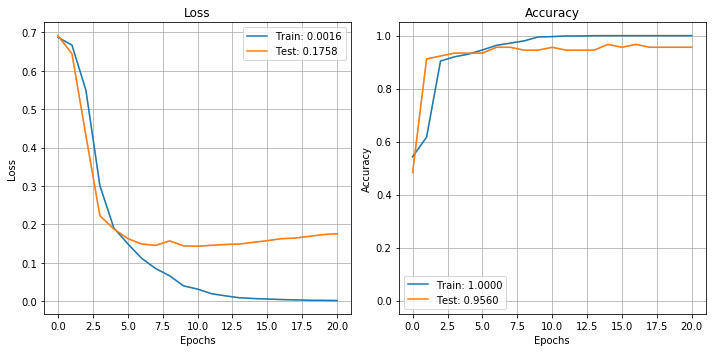

In [78]:
plot_history(history.history)

## Evaluate

In [79]:
type(batch_size)

int

In [80]:
scores = model.evaluate(X_test_pad, y_test, batch_size)

print('Test accuracy ' + str(scores[1]) + "\n")
# AUC
cnn_prob = model.predict(X_test_pad)

388/388 [==============================] - 0s 201us/step
Test accuracy 0.9587628865979382



Confusion Matrix

In [81]:
pred_bin = cnn_prob > .5

# metrics
cm = mets.confusion_matrix(y_test, pred_bin)

def printMet(met_name, fn):
    print(met_name + ": " + str(fn(y_test, pred_bin)))

printMet("Accuracy", mets.accuracy_score)
printMet("Precision", mets.precision_score)
printMet("Recall", mets.recall_score)
printMet("F1", mets.f1_score)

Accuracy: 0.9587628865979382
Precision: 0.9553072625698324
Recall: 0.9553072625698324
F1: 0.9553072625698324


In [82]:
cm

array([[201,   8],
       [  8, 171]], dtype=int64)

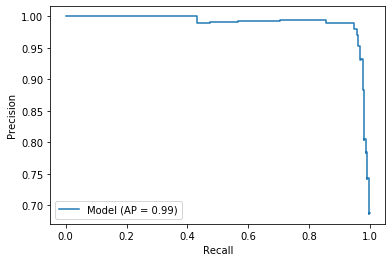

In [83]:
#Scikit-learn expects certain attributes for PR and AUROC plot
model._estimator_type = "classifier"
model.predict_proba = lambda X: np.concatenate( 
    (model.predict(X), 1-model.predict(X))
    , axis = 1)
model.classes_ = [1, 0]

mets.plot_precision_recall_curve(model, X_test_pad, y_test)

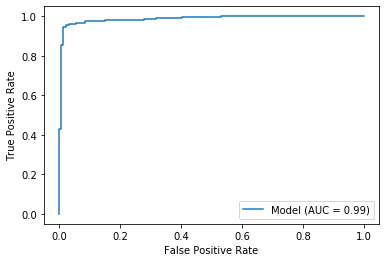

In [84]:
mets.plot_roc_curve(model, X_test_pad, y_test)